In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

os.environ['PROJECT_DIR'] = os.getcwd()
sns.set_style('whitegrid')

N_SEEDS = 15
N_ENSEMBLES = 3

AMEX_DATASET_DIRECTORY = Path('data/amex/')

MLP_EVALUATE_DIRECTORY = Path('exp/mlp/amex/plr-lite-evaluation/')
MLP_ENSEMBLE_DIRECTORY = Path('exp/mlp/amex/plr-lite-ensemble-5/')

CATBOOST_EVALUATE_DIRECTORY = Path('exp/catboost_/amex/2-evaluation')
CATBOOST_ENSEMBLE_DIRECTORY = Path('exp/catboost_/amex/2-ensemble-5')

TABR_EVALUATE_DIRECTORY = Path('exp/tabr/amex/2-plr-lite-evaluation')
TABR_ENSEMBLE_DIRECTORY = Path('exp/tabr/amex/2-plr-lite-ensemble-5')

TABR_CHECKPOINT_PATH = Path('exp/tabr/amex/2-plr-lite-evaluation/0/checkpoint.pt')

for path in [
    MLP_EVALUATE_DIRECTORY,
    MLP_ENSEMBLE_DIRECTORY,
    AMEX_DATASET_DIRECTORY,
    CATBOOST_EVALUATE_DIRECTORY,
    CATBOOST_ENSEMBLE_DIRECTORY,
    TABR_CHECKPOINT_PATH,
    TABR_EVALUATE_DIRECTORY,
    TABR_ENSEMBLE_DIRECTORY,
]:
    assert path.exists()

# Load Dataset

In [3]:
y = {}
for name in ['Y_train.npy', 'Y_val.npy', 'Y_test.npy']:
    key = name.removeprefix('Y_').removesuffix('.npy')
    y[key] = np.load(AMEX_DATASET_DIRECTORY / name)
    assert np.isnan(y[key]).sum() == 0

In [4]:
from collections import defaultdict

with open('../train_data.csv', 'r') as f:
    ORIGINAL_COLUMNS = f.readline().strip().split(',')

COLUMNS = ['D_39', 'B_1', 'R_1', 'B_4', 'B_5', 'R_2', 'D_47', 'B_7', 'D_51', 'B_9', 'R_3', 'B_10', 'S_5', 'B_11', 'S_6', 'R_4', 'B_12', 'S_8', 'R_5', 'D_58', 'B_14', 'D_60', 'S_11', 'D_65', 'B_18', 'S_12', 'R_6', 'S_13', 'B_21', 'D_71', 'S_15', 'B_23', 'P_4', 'D_75', 'B_24', 'R_7', 'R_8', 'S_16', 'R_10', 'R_11', 'S_17', 'R_12', 'B_28', 'R_13', 'R_14', 'R_15', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'R_22', 'R_23', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_26', 'D_102', 'B_36', 'B_37', 'B_40', 'D_126', 'D_127', 'B_41', 'D_133', 'R_28', 'D_140', 'D_144']

feature_class_to_description = {
    'D': 'Правонарушения',
    'S': 'Траты',
    'P': 'Платежи',
    'B': 'Баланс',
    'R': 'Риск',
}


def count_columns(columns: list[str]) -> dict[str, list[str]]:
    feature_classes = defaultdict(list)
    for col in columns:
        for key in feature_class_to_description.keys():
            if key in col:
                feature_classes[key].append(col)
                break
        else:
            assert False, 'Unreachable'
    return dict(feature_classes)


original_categories = count_columns(ORIGINAL_COLUMNS)
columns_categories = count_columns(COLUMNS)

In [5]:
print('Number of features:')
pd.DataFrame({key: [len(original_categories[key]), len(columns_categories[key])] for key in feature_class_to_description.keys()}, index=['Original', 'Preprocessed'])

Number of features:


,D,S,P,B,R
Original,97,22,3,40,28
Preprocessed,19,13,1,20,25


# Check correctness of results

In [6]:
def sort_key(s):
    s = str(s)
    dot = s.rfind('.')
    extension = '-' if dot == -1 else s[dot:]
    main_part = s[:dot]
    return extension, main_part


def print_files_for_experiment(evaluate_directory: str):
    seeds = [file for file in sorted(evaluate_directory.iterdir()) if '.toml' not in str(file)]
    print(seeds)
    print(f'Number of seeds: {len(seeds)}')
    print('Files:', *sorted(seeds[0].iterdir(), key=sort_key), sep='\n')


print_files_for_experiment(MLP_EVALUATE_DIRECTORY)

[PosixPath('exp/mlp/amex/plr-lite-evaluation/0'), PosixPath('exp/mlp/amex/plr-lite-evaluation/1'), PosixPath('exp/mlp/amex/plr-lite-evaluation/10'), PosixPath('exp/mlp/amex/plr-lite-evaluation/11'), PosixPath('exp/mlp/amex/plr-lite-evaluation/12'), PosixPath('exp/mlp/amex/plr-lite-evaluation/13'), PosixPath('exp/mlp/amex/plr-lite-evaluation/14'), PosixPath('exp/mlp/amex/plr-lite-evaluation/2'), PosixPath('exp/mlp/amex/plr-lite-evaluation/3'), PosixPath('exp/mlp/amex/plr-lite-evaluation/4'), PosixPath('exp/mlp/amex/plr-lite-evaluation/5'), PosixPath('exp/mlp/amex/plr-lite-evaluation/6'), PosixPath('exp/mlp/amex/plr-lite-evaluation/7'), PosixPath('exp/mlp/amex/plr-lite-evaluation/8'), PosixPath('exp/mlp/amex/plr-lite-evaluation/9')]
Number of seeds: 15
Files:
exp/mlp/amex/plr-lite-evaluation/0/DONE
exp/mlp/amex/plr-lite-evaluation/0/loss_train
exp/mlp/amex/plr-lite-evaluation/0/score_test
exp/mlp/amex/plr-lite-evaluation/0/score_val
exp/mlp/amex/plr-lite-evaluation/0/events.out.tfevents.

In [9]:
def load_predictions(evaluate_directory: Path) -> list[dict[str, np.ndarray]]:
    files = [file for file in sorted(evaluate_directory.iterdir()) if not str(file).endswith('.toml')]
    predictions = []
    for f in files:
        predictions.append(dict(np.load(f / 'predictions.npz')))
    return predictions


# mlp_pred_evaluate = load_predictions(MLP_EVALUATE_DIRECTORY)
mlp_pred_ensemble = load_predictions(MLP_ENSEMBLE_DIRECTORY)
catboost_pred_ensemble = load_predictions(CATBOOST_ENSEMBLE_DIRECTORY)
tabr_pred_ensemble = load_predictions(TABR_ENSEMBLE_DIRECTORY)

for key, values in mlp_pred_ensemble[0].items():
    print(key, f'len(values)={len(values)}')

train len(values)=32000
val len(values)=8000
test len(values)=10000


In [12]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score


METRICS = ['roc-auc', 'precision', 'accuracy', 'recall']


def evaluate_ensemble(y_pred_list: np.ndarray, name: str, sample: str = 'test'):
    metric_names = METRICS
    metric_values = []
    for y_pred in y_pred_list:
        y_true = y[sample]
        y_pred = y_pred[sample]
        metric_values.append(
            [
                roc_auc_score(y_true, y_pred),
                accuracy_score(y_true, y_pred >= 0.5),
                precision_score(y_true, y_pred >= 0.5),
                recall_score(y_true, y_pred >= 0.5, average='binary'),
            ]
        )
    metric_mean_values = np.mean(metric_values, axis=0)
    metric_std_values = np.std(metric_values, axis=0, ddof=1)
    metric_dict = {name: [mean] for name, mean in zip(metric_names, metric_mean_values)}
    metric_dict.update({f'{name}_std': [std] for name, std in zip(metric_names, metric_std_values)})
    return pd.DataFrame(metric_dict, index=[name])


def combine_predictions(y_pred_list_1: list[np.ndarray], y_pred_list_2: list[np.ndarray]) -> list[np.ndarray]:
    y_pred_result = []
    for y_pred_1, y_pred_2 in zip(y_pred_list_1, y_pred_list_2):
        y_pred_result.append({key: (y_pred_1[key] + y_pred_2[key]) / 2 for key in y_pred_1.keys()})
    return y_pred_result


mlp_metrics = evaluate_ensemble(mlp_pred_ensemble, 'MLP')
catboost_metrics = evaluate_ensemble(catboost_pred_ensemble, 'CatBoost')
tabr_metrics = evaluate_ensemble(tabr_pred_ensemble, 'TabR')

mlp_catboost_ensemble_metrics = evaluate_ensemble(combine_predictions(mlp_pred_ensemble, catboost_pred_ensemble), 'MLP + CatBoost')
tabr_catboost_ensemble_metrics = evaluate_ensemble(combine_predictions(tabr_pred_ensemble, catboost_pred_ensemble), 'TabR + CatBoost')
all_metrics = pd.concat([tabr_metrics, mlp_metrics, catboost_metrics, mlp_catboost_ensemble_metrics, tabr_catboost_ensemble_metrics])
all_metrics

,roc-auc,precision,accuracy,recall,roc-auc_std,precision_std,accuracy_std,recall_std
TabR,0.944342,0.884067,0.798804,0.745068,0.000320,0.000651,0.005538,0.007368
MLP,0.945772,0.885333,0.799134,0.750923,0.000203,0.000757,0.000813,0.003825
CatBoost,0.946227,0.886267,0.795823,0.760977,0.000177,0.000451,0.001668,0.000382
MLP + CatBoost,0.946894,0.887133,0.800111,0.758559,0.000184,0.000666,0.002060,0.001227
TabR + CatBoost,0.946388,0.887067,0.801371,0.756268,0.000073,0.000814,0.003956,0.003422


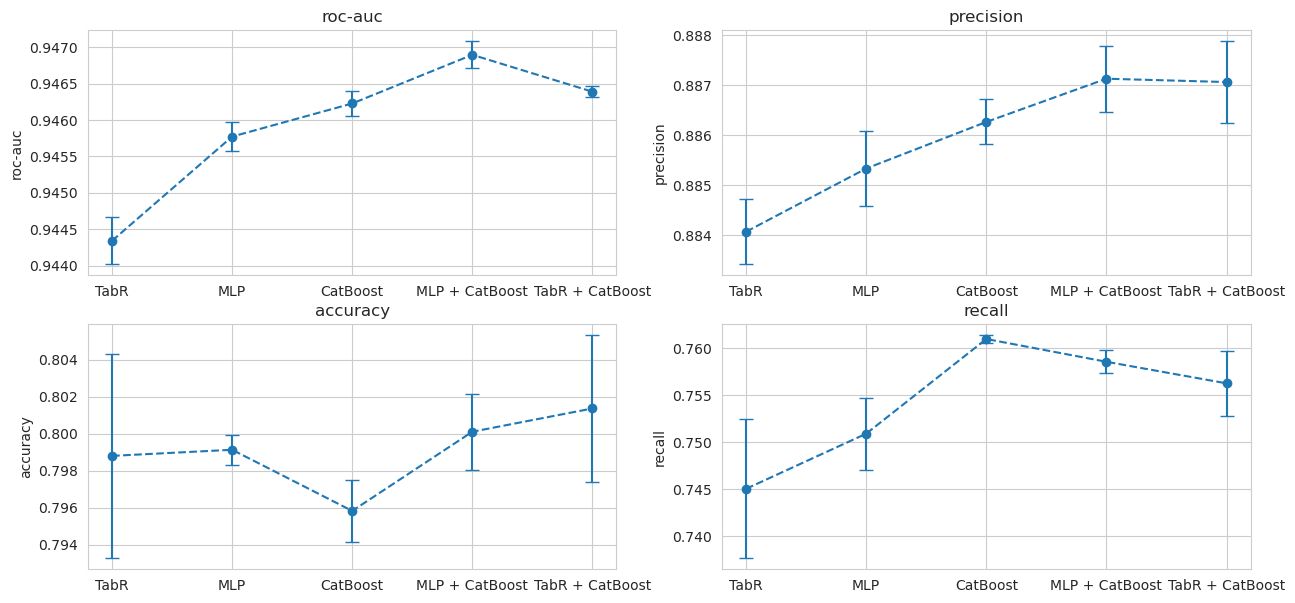

In [14]:
def visualize_metrics(df: pd.DataFrame):
    plt.subplots(2, 2, figsize=(15, 7))
    for i, metric in enumerate(METRICS):
        plt.subplot(2, 2, i + 1)
        plt.errorbar(df.index, df[metric], df[f'{metric}_std'], capsize=5, marker='o', linestyle='--')
        plt.title(metric)
        plt.ylabel(metric)
    plt.show()


visualize_metrics(all_metrics)

# Visualize feature importance

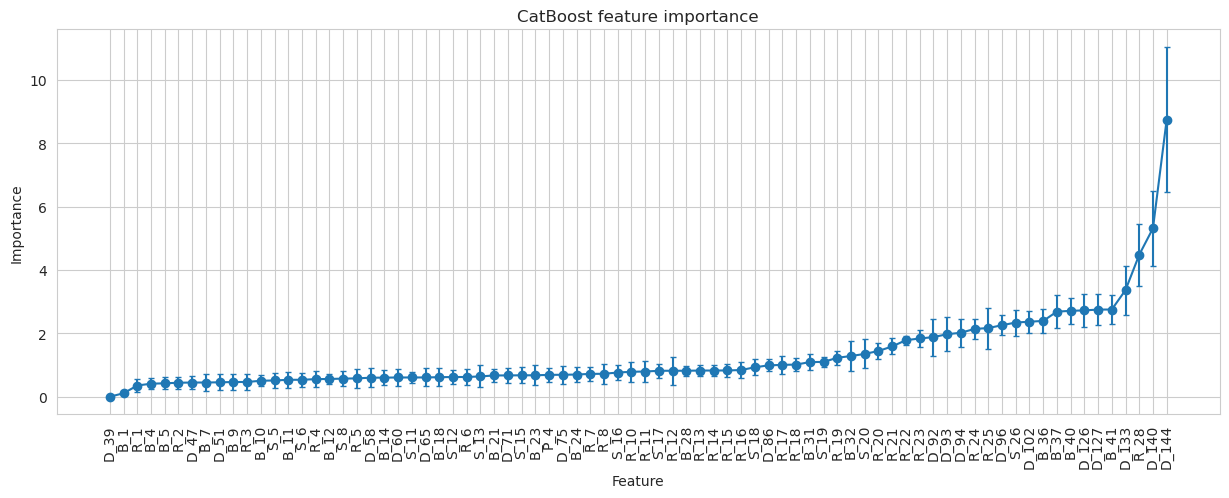

In [34]:
def get_catboost_feature_importances(evaluate_directory: Path):
    importances = []
    for i in range(N_SEEDS):
        importances.append(np.load(evaluate_directory / f'{i}/feature_importances.npy'))
    importances = np.stack(importances)
    assert importances.shape == (N_SEEDS, len(COLUMNS))
    return pd.DataFrame(importances, columns=COLUMNS)


def visualize_catboost_feature_importance(evaluate_directory: Path):
    plt.figure(figsize=(15, 5))
    importances = get_catboost_feature_importances(evaluate_directory)
    col_ind = importances.columns[np.argsort(importances.mean(axis=0))]
    importances = importances.loc[:, col_ind]
    plt.errorbar(COLUMNS, importances.mean(axis=0), importances.std(axis=0), capsize=2, marker='o')
    plt.xticks(rotation=90)
    plt.title('CatBoost feature importance')
    plt.ylabel('Importance')
    plt.xlabel('Feature')


visualize_catboost_feature_importance(CATBOOST_EVALUATE_DIRECTORY)

# Visualize training

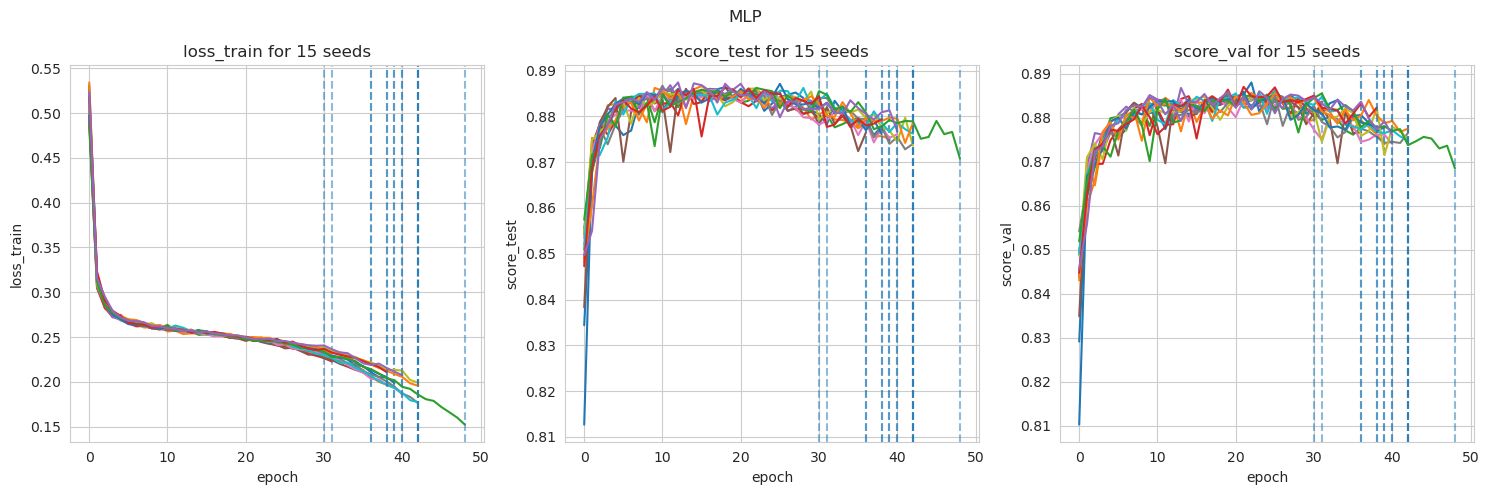

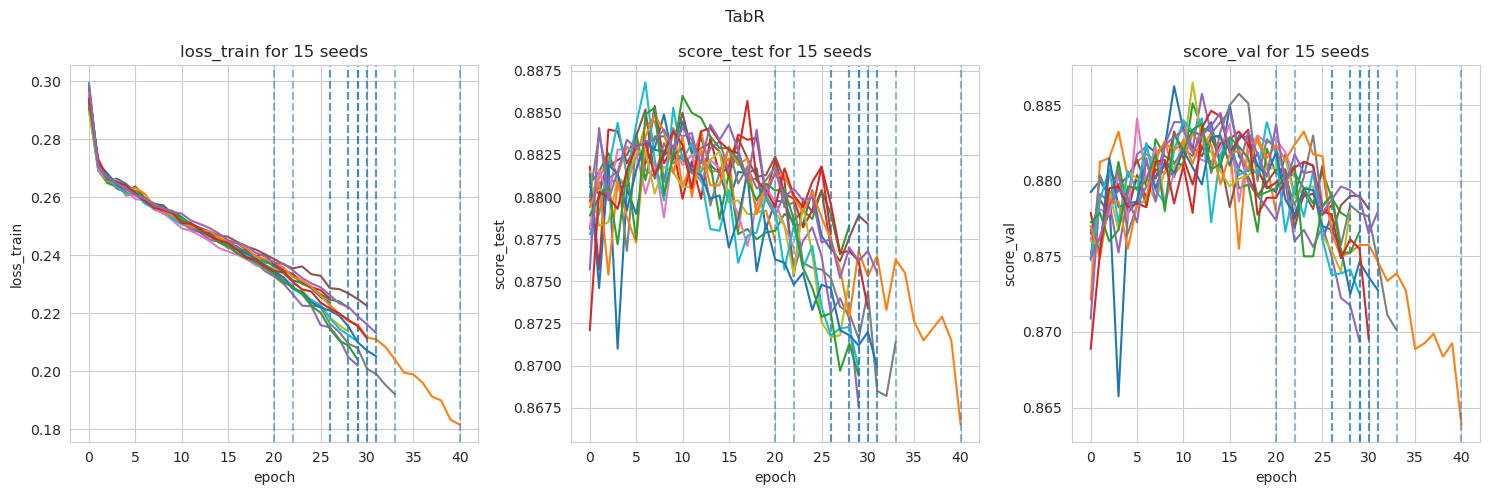

In [15]:
from tensorboard.backend.event_processing import event_accumulator


def visualize_losses(evaluate_directory: Path, model_name: str):
    plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(model_name)
    for cnt, directory in enumerate(['loss_train', 'score_test', 'score_val']):
        plt.subplot(1, 3, cnt + 1)
        for i in range(N_SEEDS):
            events_directory = evaluate_directory / str(i) / directory
            assert events_directory.exists() and len(list(events_directory.iterdir())) == 1
            event_file = next(iter(events_directory.iterdir()))
            # Create an EventAccumulator
            event_acc = event_accumulator.EventAccumulator(str(event_file))
            event_acc.Reload()

            # Get the scalar events
            scalar_events = event_acc.Scalars(event_acc.Tags()['scalars'][0])

            # Extract the step and value for each scalar event
            steps = [event.step for event in scalar_events]
            values = [event.value for event in scalar_events]

            # Print the steps and values
            # print(f'{len(steps)} steps: {values}')
            # if 'score' in directory:
            #     values = -np.array(values)
            plt.plot(steps, values, label=f'{i} seed')
            plt.axvline(steps[-1], linestyle='--', alpha=0.5)
            plt.title(f'{directory} for {N_SEEDS} seeds')
            plt.ylabel(directory)
            plt.xlabel('epoch')
        # plt.legend()
    plt.tight_layout()
    plt.show()


visualize_losses(MLP_EVALUATE_DIRECTORY, 'MLP')
visualize_losses(TABR_EVALUATE_DIRECTORY, 'TabR')

# Visualize Nearest Neighbours (deleted)